# Process ch 5-8 with changing watertank shift
here I will process channel 5-8 with the changing watertank shift.
So the watertank value measurement time will fit to the DTS measurement time.
This will give some data gaps, because the Watertank temperature is not always avaible.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file
import math

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, calc_diff_between_channels, watertank_shift, read_pickle, write_pickle, temp_watertank_func, random_date, check_first_last_date, cut_dataframe_to_range_tlogger, check_processed_data, calc_mean_for_each_segment, plot_segments_mean_correction, const_shift_data

plot_save=False #True False

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.2.3
pickle version: 4.0


In [2]:
#Load data
path_to_my_database = r"..\Alsdorf\Daten\my_database"
# data_2019 = import_my_database_csv(2019, path_to_my_database + r"\csv")
# data_2020 = import_my_database_csv(2020, path_to_my_database + r"\csv")
# data_2021 = import_my_database_csv(2021, path_to_my_database + r"\csv")

# Load pickle Data
data_all = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all")

# delete other cable channels
for old_chan in ["1","2","3","4"]:
    del data_all[old_chan]

In [3]:
# import tlogger
# read csv
# Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

#read_pickle
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

watertank_T_range_min = df_Tlogger_PT100.index.min()
watertank_T_range_max = df_Tlogger_PT100.index.max()

df_Tlogger_PT100

,Channel1-Watertank_PT100,Channel2-Air,Channel1-PT100_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-08-09 10:28:14,20.6,NaN,20.6
2021-08-09 10:31:14,20.6,NaN,20.6
2021-08-09 10:34:14,20.6,NaN,20.6
2021-08-09 10:37:13,20.6,NaN,20.6


In [4]:
data_all_processed=deepcopy(data_all)
#data_all=0 # if not doing this I can easy use it as comparisson for processed data

# remove unrealistiv values of corrected data - relativ großzügig
# channel 5, 6 825 bis 900 a lot of noise in channel 6
a=data_all_processed #for shortening code
for chan in ["5","6"]:
    for length in range(850,870,1): # from 850 to 870 (both inclusive) delete all values
        a[chan][length] = np.nan

for chan in ["7","8"]:
    for length in range(1700,1716,1): # from 1700 to 1715 (both inclusive) delete all values
        a[chan][length] = np.nan

# drop last value, because chan5 is "longer" than chan6; determined by test measurement of DTS device
a["5"] = a["5"].drop(1708,axis=1)
# adapt dataframes so that during avearaging (flipping dataframe columns), the watertank positions are avearaged
##################adapt if changing watertank position##########################
# both dataframes have a length of 1708 now (max value length 1707)
#1707-25=1682 # 25 position from the back --> 1689 of one channel is not avearaged with 25 of other channel
a["5"] = a["5"].drop([0,1,2,3,4,5,6],axis=1)
a["6"] = a["6"].drop([0,1,2,3,4,5,6],axis=1)
# 25 is now index 19 (position 20) and 1689 is index -20; index 0 is avearaged with -1 and so on

# ### test - bringt keine Verbesserung, habe 1600 und 100 auch getauscht
# # ich muss es dann reindexen, da die column names dann nicht mehr passen
# # move channel 6 to the left, at position 300 and onward
# a["5"] = a["5"].drop([1600],axis=1) # Wassertank position wird mit verschoben!!!!!!!!!!!!!
# a["6"] = a["6"].drop([100],axis=1) #remove one which is before the watertank
# # reset index so its the same for channel 5 and 6 again
# a["5"].reset_index()
# a["6"].reset_index()
# ###

a["7"] = a["7"].drop([0,1,2,3,4,5],axis=1)
a["8"] = a["8"].drop([0,1,2,3,4,5],axis=1)
# 25 is now index 19 (position 20) and 3389 is index -20; index 0 is avearaged with -1 and so on
a["7"] = a["7"].drop([1800,1801],axis=1)
a["8"] = a["8"].drop([1800,1801],axis=1)
# 1689 is now index 1683 and 1723 is index -1684
#################################################################################

###################### Correct date missmatch, must be done manually at the moment####################################
# print("--- Before removing date points ---")
# check_first_last_date(a)
# print("--- --- --- --- --- --- --- --- --- ---")
a["5"] = a["5"].drop(a["5"].index[1929],axis=0) # Measurement stop
a["5"] = a["5"].drop(a["5"].index[0],axis=0)
a["6"] = a["6"].drop(a["6"].index[0:1],axis=0)
a["7"] = a["7"].drop(a["7"].index[0:1],axis=0)
a["8"] = a["8"].drop(a["8"].index[0:1],axis=0)

# Check if the changes are as expected
#print("--- After removing some date points ---")
#check_first_last_date(a) # done in next cell anyway
####################################################################################################################

In [5]:
data_all_processed_withoutTlogger = deepcopy(data_all_processed) # used for const shift correction

# Check my processed data
my_Warning = check_processed_data(channels=["5","6","7","8"], data_all_processed = data_all_processed_withoutTlogger, gap_end=2404, gap_begin=1928)
# gap_begin=1928
# gap_end=2404
# # gap_begin=1661
# # gap_end=2137

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


In [6]:
# Cut dataframes so they only cover the time of the t-Logger
# only cuts start and end does not account for datagaps in tlogger!

#do seperate due to data gaps, therefore iloc of the dates is not corresponding to same date_name
data_all_processed_56 = cut_dataframe_to_range_tlogger(channels=["5","6"],data = data_all_processed,do_check=False, 
    watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max)
data_all_processed_78 = cut_dataframe_to_range_tlogger(channels=["7","8"],data = data_all_processed,do_check=False,
    watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max)
data_all_processed["5"] = data_all_processed_56["5"]
data_all_processed["6"] = data_all_processed_56["6"]
data_all_processed["7"] = data_all_processed_78["7"]
data_all_processed["8"] = data_all_processed_78["8"]
data_all_processed_78=0; data_all_processed_56=0

In [7]:
# Add Manual correction here##################################
data_all_processed["7"] = data_all_processed["7"].drop(data_all_processed["7"].index[0],axis=0)
data_all_processed["8"] = data_all_processed["8"].drop(data_all_processed["8"].index[0],axis=0)
# für übergangslösung !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
data_all_processed["7"] = data_all_processed["7"].drop(data_all_processed["7"].index[-1],axis=0)
data_all_processed["8"] = data_all_processed["8"].drop(data_all_processed["8"].index[-1],axis=0)
##########
a=data_all_processed
a["5"] = a["5"].drop(a["5"].index[-1],axis=0)
a["6"] = a["6"].drop(a["6"].index[-1],axis=0)
############################################
# check_first_last_date(data_all_processed) done in next cell anyway

In [8]:
# Check my processed data
my_Warning = check_processed_data(channels=["5","6","7","8"], data_all_processed = data_all_processed, gap_begin=1661, gap_end=2137)
# gap_begin=1928
# gap_end=2404
# # gap_begin=1661
# # gap_end=2137

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


# Shift processed data to watertank

In [9]:
##26.2 s
#25 1689 1723 3389
#1688 evntl besser !!!!!!!!!!!!!!!!!!!!!!!!
watertank_len=[25,1689,1723,3389] # position DTS cable, where it is in watertank; vorher [19,1690,1723,3389]
# Wie habe ich aktuell die Wassertank positionen bestimmt: 
# watertank angeguckt und die position finden wo starke änderrungen sind über die Zeit sin --> draußen
# Zwei bis drei Längeneinheiten richtung DTS Gerät gegangen, dort sind dann keine starken Änderrungen über die Zeit 
    # --> Wassertankposition
# Dann die Dataframes von den Channeln die ich mittele so bearbeiten, dass genau die Wassertank positionen gemittelt werden
    # ein parr Längen /Spalten entfernt
# Positionen sind nicht ganz richtig, oder Längen die vom DTS Kabel generiert wurden stimmen nicht

# Correction for waterteank temp difference
data_all_processed_shifted, watertank_diff_log_data_all = watertank_shift(data_all_processed, df_Tlogger_PT100, watertank_len=watertank_len,watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Calculate mean of channels

In [10]:
def avearge_two_channels(chanx,chany):
    """one channel (chanx) is flipped (length). After that the mean of all values is calculated.
    Only use this for processed data
    """
    # Calculate new index
    # calculate mean of both indexes and check the time difference; checking the time difference is not needed anymore
    #because its already done data processing check. But I think it does not take much computing power, so I left it here
    time_diff_allowed = 5
    new_index=[]
    for i in range(len(chanx)):
        ts1=chanx.index[i] # ts: timestamp
        ts2=chany.index[i]
        # calculate mean time of both channels, it will be used as index for the result.
        if ts1 > ts2:
            tsmean=ts1+(ts1-ts2)/2
            if ts1-ts2 > timedelta(minutes=time_diff_allowed): 
                print(f"Warning 1: Large time difference between both channels: {ts1-ts2}")
        elif ts1 < ts2:
            tsmean=ts2-(ts1-ts2)/2
            if -(ts1-ts2) > timedelta(minutes=time_diff_allowed):
                print(f"Warning 2: Large time difference between both channels: {-(ts1-ts2)}")
        else:
            print("Warning 3: Timestamps equal. Not expected")
        new_index.append(tsmean.round(freq="S"))
    new_index=pd.Series(new_index,name="Date") # to series so it can be used in .set_index

    # change index, so they are equal
    chany = chany.set_index(new_index)
    chanx = chanx.set_index(new_index)
    # flip dataframe one channel (channel 5)
    # Two possibilities
    # 1. Flip data of dataframe
    # chanx = chanx[chanx.columns[::-1]] # flip the whole dataframe: columns and data
    # chanx.columns = chanx.columns[::-1] # datframes are added based on column names, so I need to change them in one dataframe
    # 2. flip only columns (rename them), because by adding two dataframes the values with the same column name are added
    chanx_flipped = deepcopy(chanx) # otherwise I will flip the chanx dataframe for the rest of the notebook
    chanx_flipped.columns = chanx_flipped.columns[::-1]
    # calculate mean of Temperature values
    chanxy_mean = (chanx_flipped + chany)/2

    return chanxy_mean

# Create mean of channels
chan5and6_mean = avearge_two_channels(data_all_processed_shifted["5"], data_all_processed_shifted["6"])
chan7and8_mean = avearge_two_channels(data_all_processed_shifted["7"], data_all_processed_shifted["8"])

chan_mean_shiftfirst={}
# columns (length) corresponds to second channel, channel 6 and channel 8
chan_mean_shiftfirst["5and6"]=chan5and6_mean
chan_mean_shiftfirst["7and8"]=chan7and8_mean

# Avearge first and make the watertank correction after that
**Idee:** Ich könnte auch beide Channel vor dem aveargen auf das gleiche Nivau bringen, also Differenz der Mittelwerte nehmen und beide Kurven so verschieben, dass sie den gleichen Mittelwert haben. Dann Mitteln und danach auf Wassertank position verschieben.

In [11]:
#40s
chan5and6_mean_aveargefirst = avearge_two_channels(data_all_processed["5"], data_all_processed["6"])
chan7and8_mean_aveargefirst = avearge_two_channels(data_all_processed["7"], data_all_processed["8"])
chan_mean_avearagefirst={}
chan_mean_avearagefirst["5and6"]=chan5and6_mean_aveargefirst
chan_mean_avearagefirst["7and8"]=chan7and8_mean_aveargefirst

# auf Wassertank verschieben bei watertank_len[0] m
chan_mean_avearagefirst, watertank_diff_log_avearagefirst = watertank_shift(chan_mean_avearagefirst, df_Tlogger_PT100, channels=["5and6","7and8"],  watertank_len=watertank_len, watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Save processed data

In [12]:
write_pickle(path_to_my_database + "\..\my_database_additional_local\chan_mean_avearagefirst",chan_mean_avearagefirst)
write_pickle(path_to_my_database + "\..\my_database_additional_local\watertank_diff_log_data_all",watertank_diff_log_data_all)
write_pickle(path_to_my_database + "\..\my_database_additional_local\data_all_processed",data_all_processed)
write_pickle(path_to_my_database + "\..\my_database_additional_local\data_all_processed_shifted",data_all_processed_shifted)
write_pickle(path_to_my_database + "\..\my_database_additional_local\watertank_diff_log_avearagefirst",watertank_diff_log_avearagefirst)
write_pickle(path_to_my_database + "\..\my_database_additional_local\chan_mean_shiftfirst",chan_mean_shiftfirst)




# Process ch 5-8 with mean watertank shift
here I will process channel 5-8 with the mean watertank shift.
Therefore I will divide the data in different "QuickStart" sets.

## Is correction time dependent?

In [14]:
# divide into segments of the same kalibration (QuickStart)
# "22-07-2021 13:30:29" angepasst, sodass es besser zu Daten passt
# "14-07-2021 14:16:59" angepasst, sodass es besser zu Daten passt
string=["2021-06-01 15:06:12", "14-07-2021 12:58:00", "22-07-2021 11:50:00", "2021-08-02 11:08:00"]
dates=[pd.to_datetime(s) for s in string] #also used later for plotting
first_date=data_all["5"].index[0]
last_date=data_all["8"].index[-1]

calibration_segments = []
first_segment=[first_date, dates[1]]
last_segment=[dates[-1],last_date]

calibration_segments.append(first_segment)
for i in range(1,len(dates[1:])): #skip first one
    segment = [dates[i], dates[i+1]]
    calibration_segments.append(segment)
calibration_segments.append(last_segment)

In [15]:
result = calc_mean_for_each_segment(["5","6","7","8"], calibration_segments, watertank_diff_log_data_all, watertank_len)
calibration_segments_mean_correction = result[0]
calibration_segments_mean_correction_dates = result[1]
del result

c:\Users\Mathis\Desktop\Masterarbeit\Scripts\my_func_mvw\functions.py:348: RuntimeWarning: Mean of empty slice
  segment_mean = np.nanmean(data[date_iloc_start+5:date_iloc_end-5])


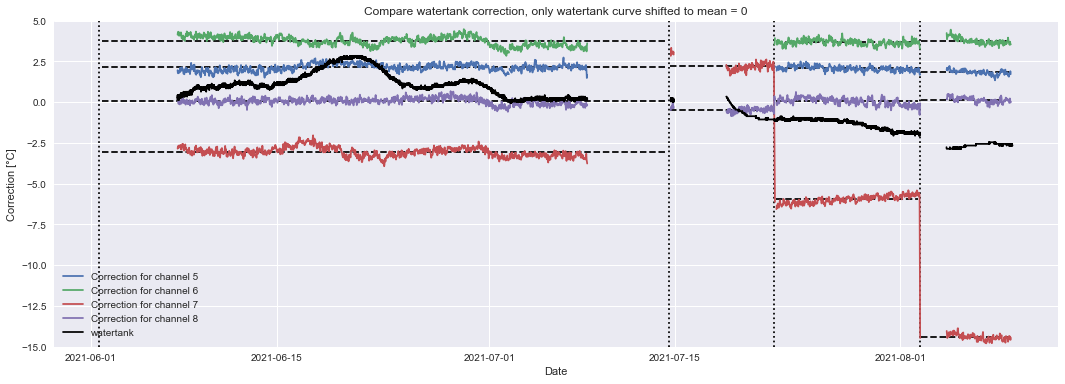

In [18]:
plot_segments_mean_correction(calibration_segments_mean_correction,dates,calibration_segments_mean_correction_dates,watertank_diff_log_data_all,df_Tlogger_PT100,watertank_len,ymax=5, ymin=-15)

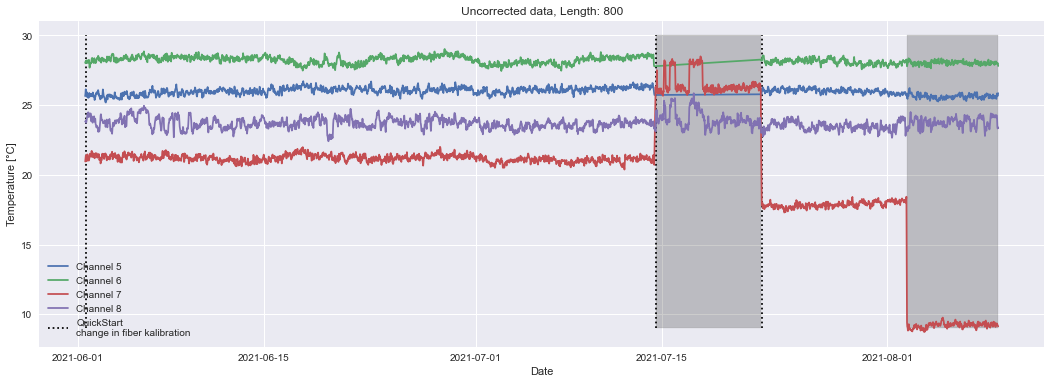

In [19]:
fig,axs=plt.subplots(1,1,figsize=(18,6))
length=800
# divide into segments of the same kalibration (QuickStart)
# ich glaube nicht das an jedem von diesem Datums der Quickstart neu gemacht wurde
string=["22-07-2021 13:30:29", "14-07-2021 14:16:59","2020-12-09 11:02:45", "2021-04-07 12:43:35", "2021-04-26 10:57:11",
    "2021-04-28 09:41:06", "2021-05-20 16:02:01", "2021-06-01 15:06:12"]
string=["2021-06-01 15:06:12", "14-07-2021 14:16:59", "22-07-2021 13:30:29"]
dates=[pd.to_datetime(s) for s in string]
axs.vlines(dates,9,30,colors="black",linestyle=":",label="QuickStart\nchange in fiber kalibration")

for chan in ["5","6","7","8"]:
    axs.plot(data_all[chan][length],label=f"Channel {chan}")

# Correction Segments
def color_cable_pos(calibration_segment, alph, ymax=30, ymin=9, col="black", label_name="none", label=False, axs=axs):
    """ creates patches which color the plot
    I slightly adapt this for every notebook
    """
    start_len = calibration_segment[0]
    end_len = calibration_segment[1]
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

color_cable_pos(calibration_segments[0],0.0)
color_cable_pos(calibration_segments[1],0.2)
color_cable_pos(calibration_segments[2],0.0)
color_cable_pos(calibration_segments[3],0.2)

axs.set_title(f"Uncorrected data, Length: {length}")
axs.set_xlabel("Date")
axs.set_ylabel("Temperature [°C]")
axs.legend()

plt.show()

# Correct data with const shift for each segment
Advantage: no datagaps (only the ones I want to have at segment borders)
at the moment the shift is determined with the data of the atertank correction for each sgement.

But especially for the older data of chan 1 - 4 I want to determine it from the raw data. This should be also usefull for the EGRT segment due to the large data gaps.

In [30]:
data_all_processed_constshifted = const_shift_data(["5","6","7","8"],calibration_segments, calibration_segments_mean_correction,data_all_processed_withoutTlogger)

In [21]:
# drop dates which cant be corrected with good results
data_all_processed_constshifted["7"].iloc[2402] = np.nan
data_all_processed_constshifted["7"].iloc[2403] = np.nan

# maybe I should delete at every border some values. Because the device needs some time to warm up?

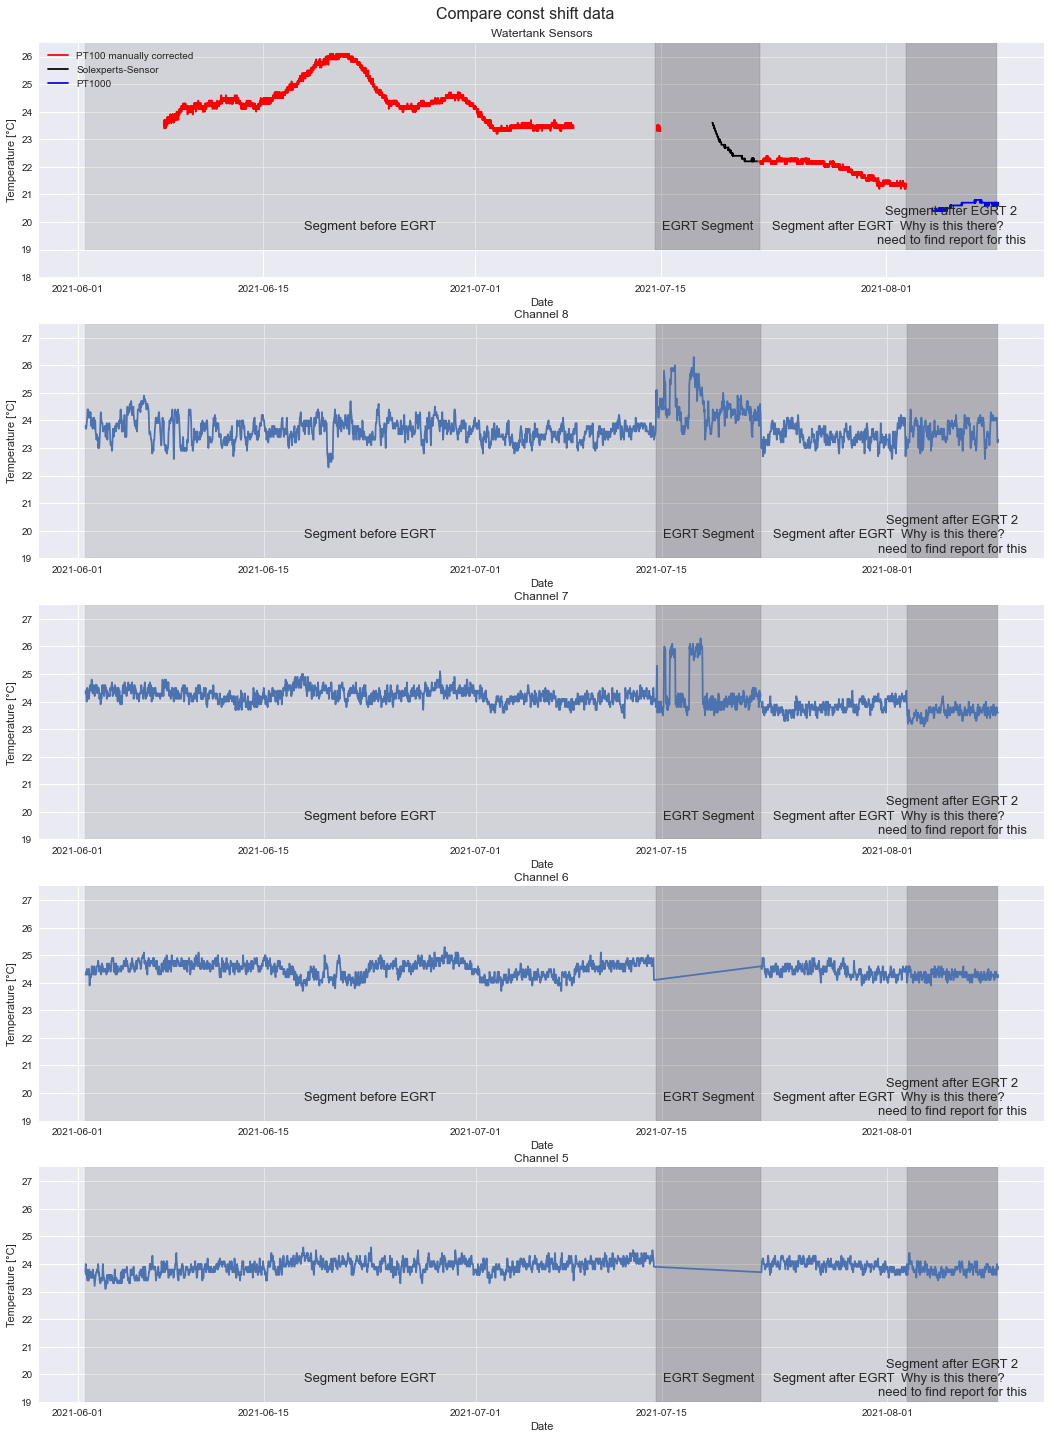

In [28]:
cable_length=800 #watertank_len=[25,1689,1723,3389]
fig,axs=plt.subplots(5,1,figsize=(18,25))
fig.suptitle("Compare const shift data", fontsize = 16, y=0.90)
ymin=18; ymax=26.5
dftlog=df_Tlogger_PT100["Channel1-Watertank_PT100"]
# are not perfectly chosen, but due to data gaps its looks ok
border_temp1=20000
border_temp2=26000
border_temp3=32500
axs[0].plot(dftlog[:border_temp1].index,dftlog[:border_temp1].values,color="red", label="PT100 manually corrected")
axs[0].plot(dftlog[border_temp1:border_temp2].index,dftlog[border_temp1:border_temp2].values,color="black", label="Solexperts-Sensor")
axs[0].plot(dftlog[border_temp2:border_temp3].index,dftlog[border_temp2:border_temp3].values,color="red")
axs[0].plot(dftlog[border_temp3:].index,dftlog[border_temp3:].values,color="blue", label="PT1000")
#axs[0].vlines(dates,ymin,ymax,colors="black",linestyle=":")



axs[0].set_ylim(ymin,ymax)
axs[0].set_title("Watertank Sensors")
axs[0].legend()

ax_help=9; ymin=19; ymax=27.5 # same length as axs[0]
for chan in ["5","6","7","8"]:
    #axs.plot(data_all_processed_shifted[chan][800], label=f"variable shift, channel {chan},")#, color="blue")

    axs[ax_help-int(chan)].plot(data_all_processed_constshifted[chan][cable_length])#, color="green")
    
    axs[ax_help-int(chan)].set_title(f"Channel {chan}")
    axs[ax_help-int(chan)].set_ylim(ymin,ymax)

for ax in axs:
    #ax.legend()
    ax.set_ylabel("Temperature [°C]")
    ax.set_xlabel("Date")
    color_cable_pos(calibration_segments[0],0.1, ymax=ymax, ymin=ymin,axs=ax,label_name="Segment before EGRT", label=True)
    color_cable_pos(calibration_segments[1],0.25, ymax=ymax, ymin=ymin,axs=ax,label_name="EGRT Segment", label=True)
    color_cable_pos(calibration_segments[2],0.1, ymax=ymax, ymin=ymin,axs=ax,label_name="Segment after EGRT", label=True)
    color_cable_pos(calibration_segments[3],0.25, ymax=ymax, ymin=ymin,axs=ax,label_name="Segment after EGRT 2\nWhy is this there?\nneed to find report for this", label=True)

# wenn ich beim letzten Segment mehr Daten habe passt es evntl besser? Oder ich muss erstes Segment noch um 0.1 mehr verschieben?
# Vergleich zwischen channel 7 und 8 für zweites segment sehr komische
# es könnte auch sein, dass channel 8 bemessen wurde als die Heizphase gerade aus gemacht wurde
# Für diesen Test sind kurze Messzeiten auf Kosten der Genauigkeit besser, da sich Temperatur ja schnell ändert
# erklärt es aber eigentlich nicht wirklich, müsste dann trotzdem viel ähnlicher sein
# es sieht so aus als ob channel 8 in segment 2 noch Manuel etwas nach unten verschoben werden sollte
# letztes Segment in channel 7 manuel nach oben verschieben?

## Intepretation
* PT100 manually corrected auf Solexperts Sensor: -1.5
* Im Segment von Solexperts Sensor sind auch ein paar Datenpunkte die PT100 manually corrected sind
* PT1000 sind die aktuellen Wassertank Messungen mit den neu installierten und kalibrierten Sensoren
* zweites PT100 manually corrected Segment bei channel 7 ist auch in Rohdaten ein const Steigung der Temp zu sehen
* Solexperts Sensor segment channel 8 manuell noch etwas nach unten verschieben, damit Daten konsistenter sind?
  * bei 25 ist der Sprung nicht so deutlich zu sehen

--> Norbert fragen in wie weit ich Daten verschieben soll, sodass sie in sich konsistent sind

In [23]:
# Save const shift
write_pickle(path_to_my_database + "\..\my_database_additional_local\data_ch5-8_processed_constshifted",data_all_processed_constshifted)

# dann mit channel 1 - 4 anfangen und dort const shift machen

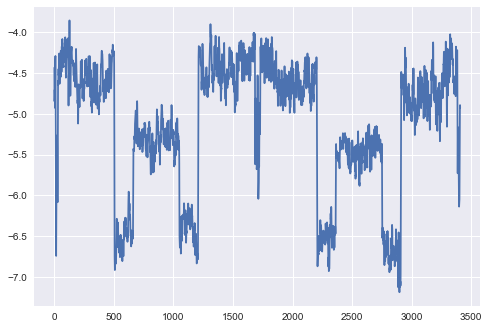

In [24]:
# Vergleichplot
# über große Zeiten ändert sich die Temperatur relativ stark
# Im Schacht aber eher nicht
# man muss drauf achten, dass beide Seiten gleich viel Tag und Nacht haben und gleiches Wetter
x=42 # how many dates to use for mean; one channel makes about 42 measurements in 24 hours
segment_border=1929 #1929, position of segment border; change it to a non-segment border for comparisson to that this method is not good
mean = data_all["7"].iloc[segment_border-x:segment_border].mean(axis=0) - data_all["7"].iloc[segment_border:segment_border+x].mean(axis=0)
plt.plot(mean)

# Sehr interressant könnte ich Norbert zeigen